<h1>CM3015 Mid-term coursework</h1>

<h1>Importing packages</h1>

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
import numpy as np
import pandas as pd

# Data Preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import zscore

# Importing models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Evaluation packages
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.datasets import load_wine

# Graphic packages
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


<h1>4. Methodology</h1>

<h2>1. Exploratory Data Analysis</h2>

<h3>1.1 Loading data</h3>

In [2]:
# load data
wine= load_wine()

# Convert the dataset into a Pandas DataFrame for better exploration
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
wine_df.shape

(178, 14)

<h3>1.2 Observing the data types and non-null count</h3>

In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

<h3>1.3 Checking whether we need to scale data or not</h3>

In [5]:
X = wine_df
y = X.pop("target")
summary_statistics = X.describe()
summary_statistics

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [6]:
# Check if features need scaling based on the range of values
feature_ranges = summary_statistics.loc[['max']].T
features_to_scale = feature_ranges[feature_ranges['max'] > 1].index.tolist()

features_to_scale

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

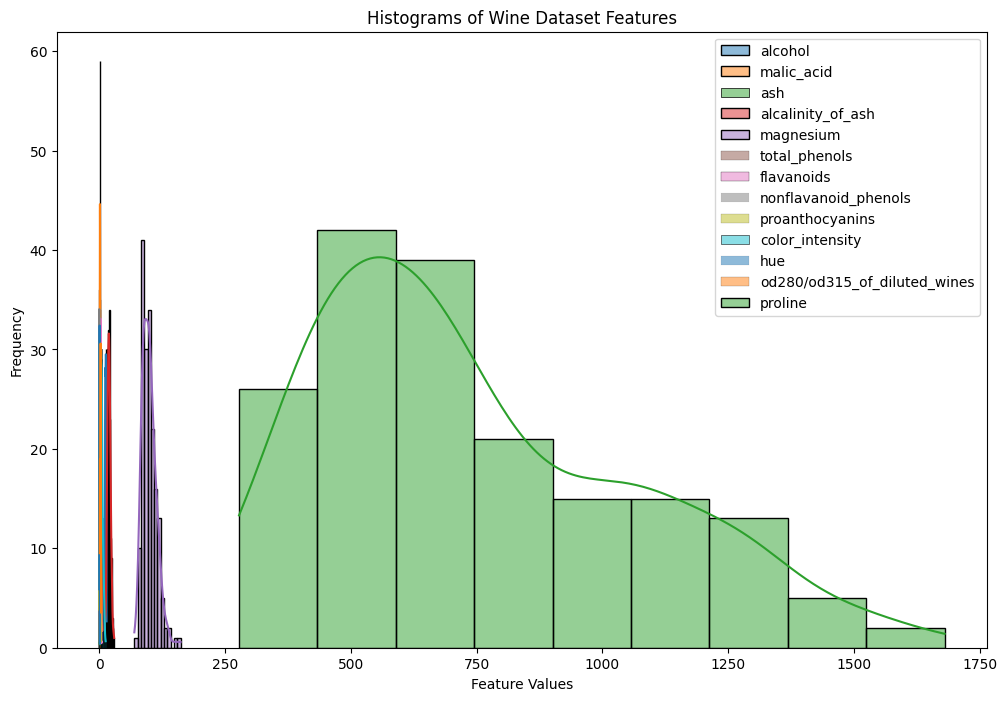

In [7]:
# Plot histograms for each feature
plt.figure(figsize=(12, 8))
for feature in X.columns:
        sns.histplot(X[feature], kde=True, label=feature)

plt.title("Histograms of Wine Dataset Features")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

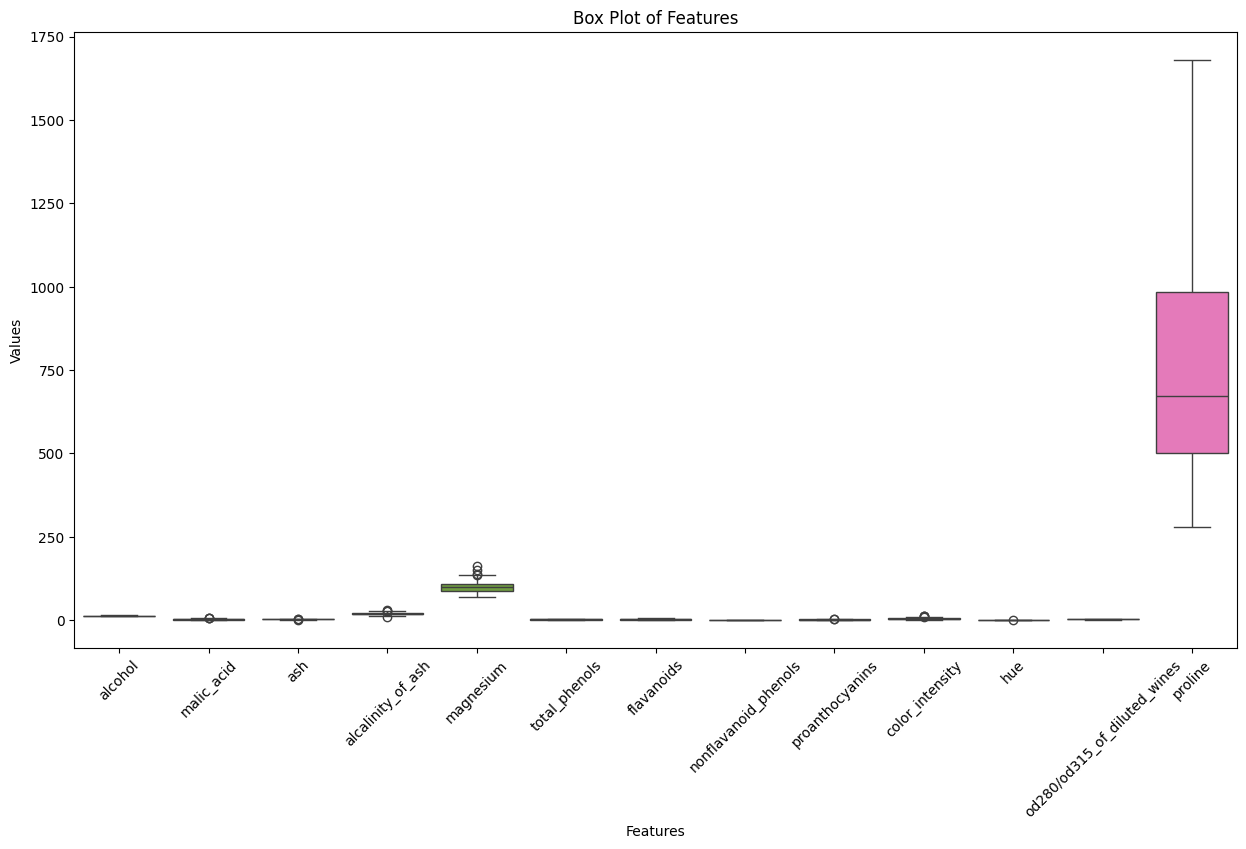

In [8]:
# Create box plots for each feature
plt.figure(figsize=(15, 8))
sns.boxplot(data=X)
plt.title("Box Plot of Features")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.show()

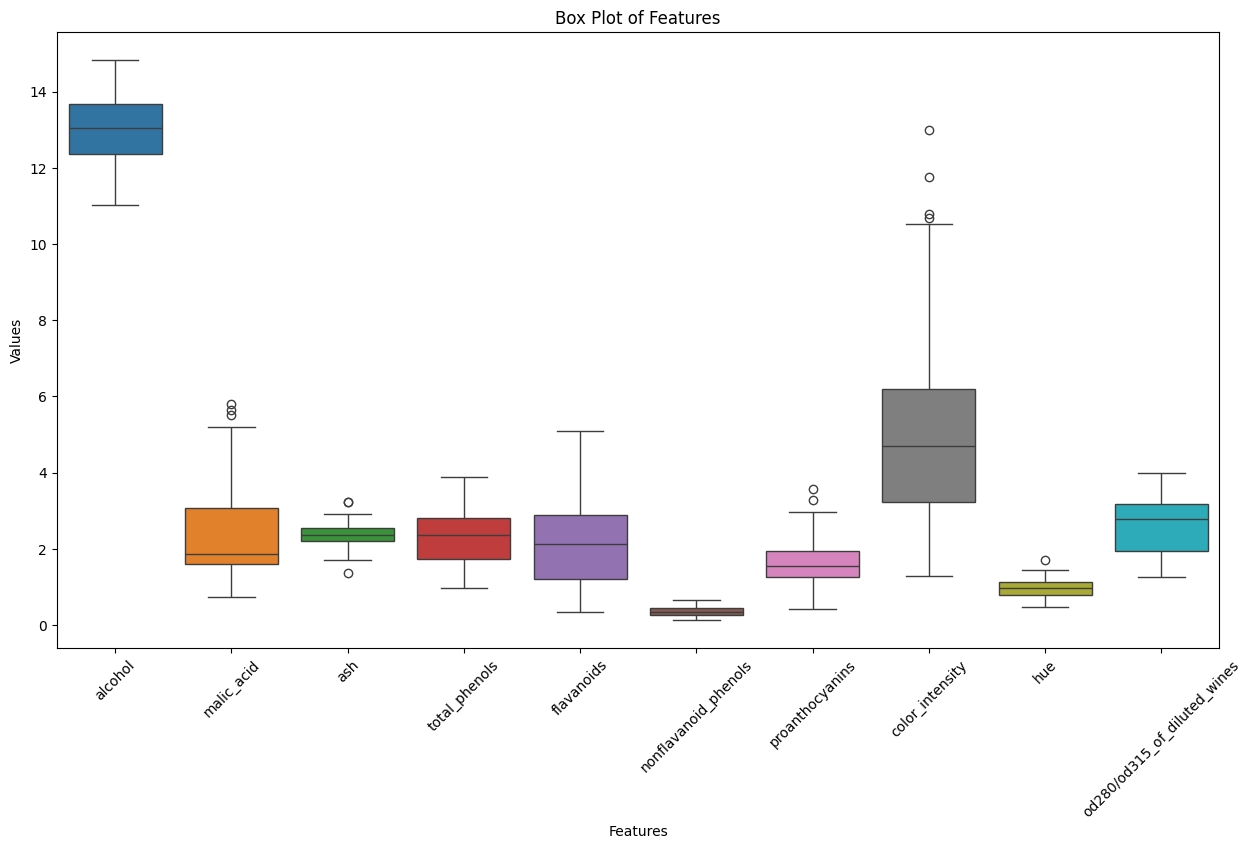

In [9]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=X[["alcohol", "malic_acid", "ash", "total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins", "color_intensity", "hue", "od280/od315_of_diluted_wines"]])
plt.title("Box Plot of Features")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.show()

<h3>1.4 Checking whether dataset is balance or not</h3>

In [10]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

<h3>1.5 Choosing validation method</h3>

In [11]:
total_data_points = len(X) 
total_data_points
validation_method = ""
if total_data_points < 1000:
    # Use k-Fold cross-validation for small datasets
    validation_method = "k-Fold Cross-Validation"
else:
    # Use cross-validation on a validation dataset for large datasets
    validation_method = "Cross-Validation on a Validation Dataset"
validation_method

'k-Fold Cross-Validation'

<h3>1.6 Detecting outliers</h3>

In [32]:
def calculate_iqr_bounds(data):
        q75, q25 = np.percentile(data, [75 ,25])
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        return lower_bound, upper_bound

In [33]:
def outliers_detection(data_frame):
    outliers_indices = []

    for column in data_frame.columns:
        data = np.array(data_frame[column])
        lower_bound, upper_bound = calculate_iqr_bounds(data)

        # Get the indices of outliers for the current column
        column_outliers_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
        
        # Append the indices to the overall list
        outliers_indices.extend(column_outliers_indices)

    # Remove duplicates, if any
    outliers_indices = list(set(outliers_indices))

    return outliers_indices

outliers_indices = outliers_detection(X)
outliers_indices

[1, 71, 13, 143, 48, 113, 150, 89, 93, 63]

<h3>1.7 Baseline accuracy</h3>

In [14]:
# Calculate the baseline accuracy
baseline_accuracy = y.value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.40


<h2>2.Data Pre-Processing</h2>

<h3>2.1 Removing outliers</h3>

In [15]:
def remove_outliers(X, y):
    # Combine X and y into a single DataFrame
    combined_data = pd.concat([X, y], axis=1)

    # Iterate over columns and remove outliers
    for column in combined_data.columns:
        if column == "target":
            continue
        data = np.array(combined_data[column])
        lower_bound, upper_bound = calculate_iqr_bounds(data)

        # Remove outliers
        combined_data = combined_data[(data >= lower_bound) & (data <= upper_bound)]

    # Separate X and y again
    X_cleaned = combined_data.drop(columns=[y.name])
    y_cleaned = combined_data[y.name]

    return X_cleaned, y_cleaned

In [16]:
X, y = remove_outliers(X, y)

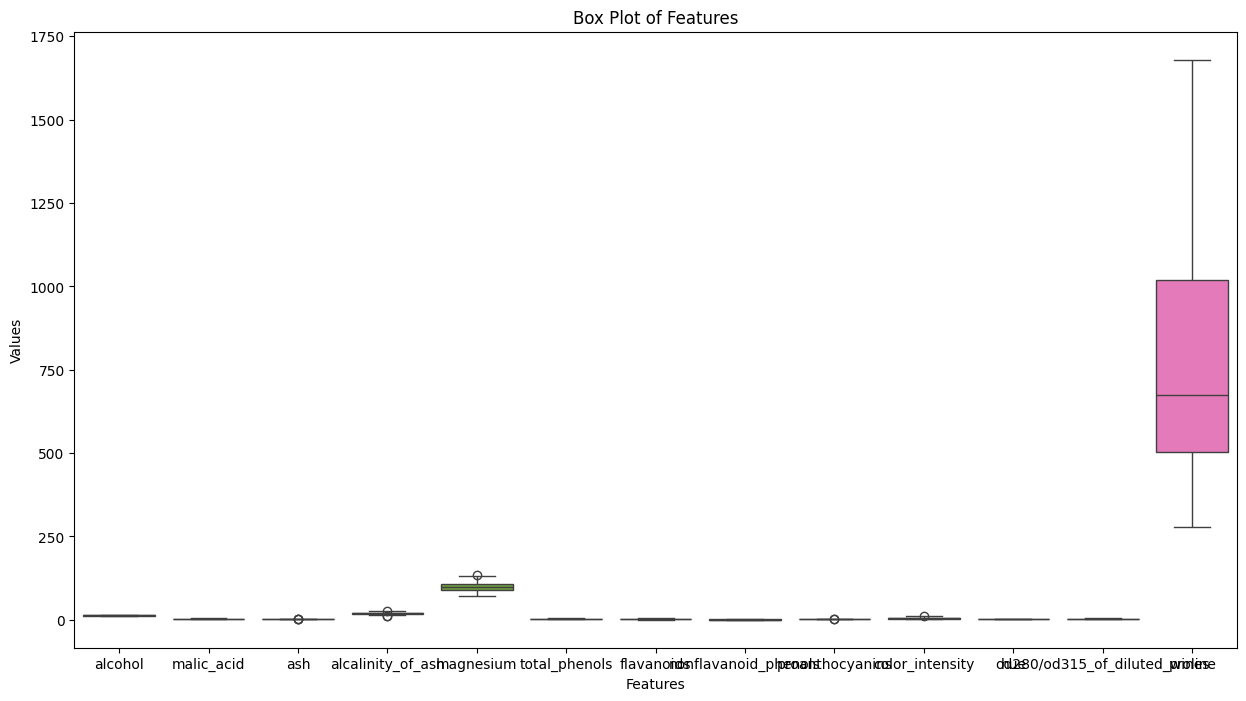

In [17]:
# Create box plots for each feature
plt.figure(figsize=(15, 8))
sns.boxplot(data=X)
plt.title("Box Plot of Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

<h3>2.2 Train-Test Split</h3>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=999)

<h3>2.3 Feature Scaling</h3>

In [19]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing sets
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.transform(X_test)

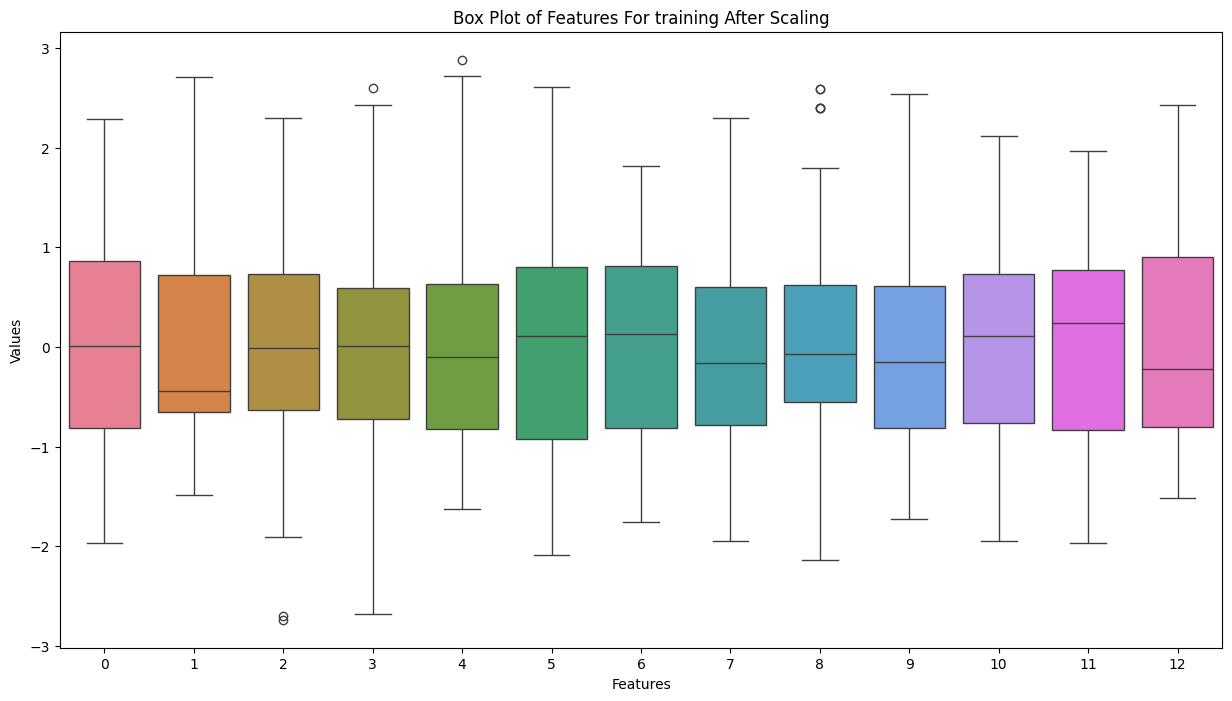

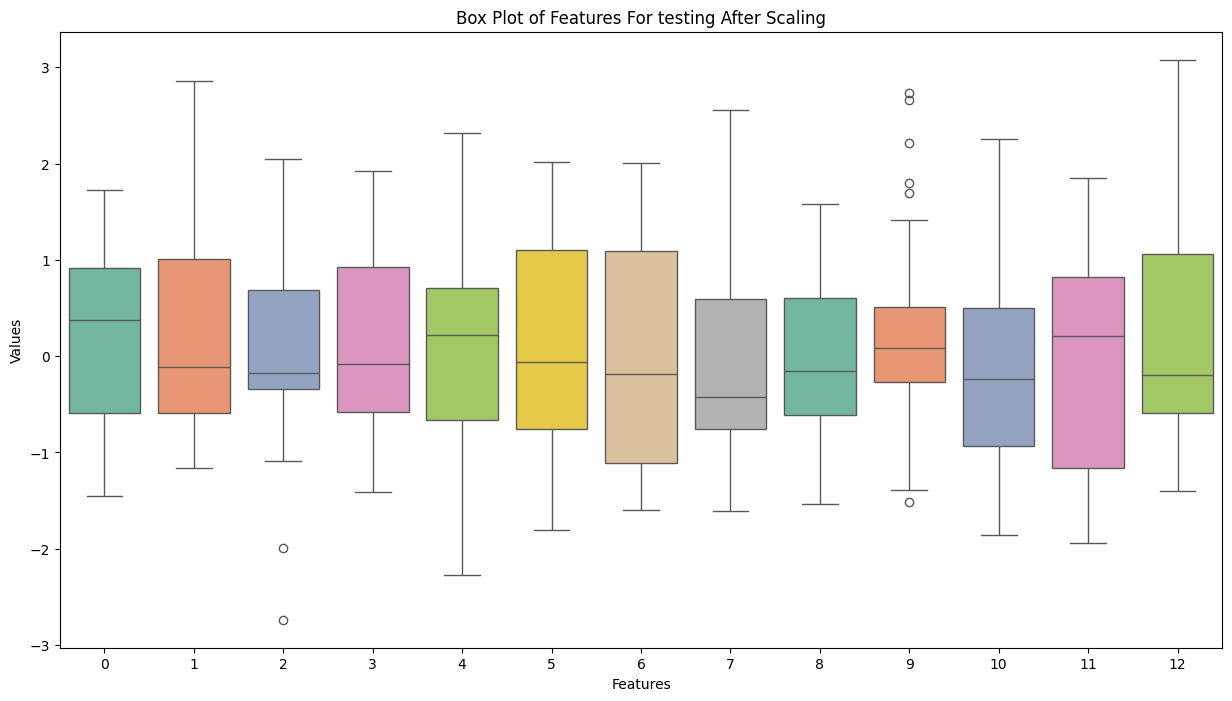

In [20]:
# Create box plots for each feature
plt.figure(figsize=(15, 8))
sns.boxplot(data=Xs_train)
plt.title("Box Plot of Features For training After Scaling")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

# Box plot after scaling
plt.figure(figsize=(15, 8))
sns.boxplot(data=Xs_test, palette="Set2")
plt.title("Box Plot of Features For testing After Scaling")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

<h2>3. Machine Learning Algorithm</h2>

In [21]:
# Model Evaluation
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test, predictions)
    
    return accuracy, precision, recall, f1, conf_matrix

In [22]:
def print_evaluation(model, model_name, X_test, y_test):
    accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, X_test, y_test)

    # Print results
    print(f"{model_name}:")
    print(f"  Accuracy:   {accuracy:.4f}")
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  F1 Score:   {f1:.4f}")

    
    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

<h3>3.1 Custom KNN Algorithm</h3>

In [23]:
class KNNClassifier:
    def __init__(self, k=3, p=2, weighting="uniform"):
        """
        KNNClassifier initialization.
        
        Parameters:
        - k: Number of neighbors to consider (default is 3).
        - p: Minkowski distance parameter (default is 2 for Euclidean distance).
        - weighting: Method for weighting votes ('uniform' or 'distance', default is 'uniform').
        """
        self.k = k
        self.p = p
        self.X_train = None
        self.y_train = None
        self.classes_ = np.unique(y_train)  # Set the unique classes
        if not (weighting in ["uniform", "distance"]):
            raise ValueError("Unsupported weighting method.")
        self.weighting = weighting

    def fit(self, X_train, y_train):
        """
        Fit the model with training data.
        
        Parameters:
        - X_train: Training features.
        - y_train: Training labels.
        """
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
        # self.classes_ = np.unique(y_train)  # Set the unique classes

    def predict(self, X_test):
        """
        Predict labels for test data.
        
        Parameters:
        - X_test: Test features.
        
        Returns:
        - predictions: Predicted labels.
        """
        predictions = []
        for x_test in X_test:
            distances = self.calculate_distances(x_test)
            sorted_indices = np.argsort(distances)

            k_nearest_labels = self.y_train[sorted_indices[:self.k]]

            if self.weighting == 'uniform':
                # Uniform weighting
                most_common_label = np.argmax(np.bincount(k_nearest_labels))
            else:
                # Weighted by inverse distances
                weighted_votes = 1 / (distances[sorted_indices[:self.k]] + 1e-10)
                weighted_counts = np.bincount(k_nearest_labels, weights=weighted_votes)
                most_common_label = np.argmax(weighted_counts)

            predictions.append(most_common_label)
        return predictions

    def calculate_distances(self, x):
        """
        Calculate distances between a test point and all training points.
        
        Parameters:
        - x: Test point.
        
        Returns:
        - distances: Array of distances.
        """
         # Ensure both self.X_train and x are numeric
        if not all(isinstance(val, (int, float)) for val in np.ravel(self.X_train)) or not all(isinstance(val, (int, float)) for val in x):
            raise ValueError("Data types must be numeric for distance calculation.")
    
        # Convert to float for consistent data types
        distances = np.linalg.norm(self.X_train.astype(float) - np.asarray(x).astype(float), ord=self.p, axis=1)
        return distances
    
    def get_params(self):
        """
        Get parameters of the KNN classifier.
    
        Parameters:
    
        Returns:
        - params : dictionary of parameters
        """
        return {'k': self.k, 'p': self.p, 'weighting': self.weighting}

    def set_params(self, **params):
        """
        Set the parameters of the KNN classifier.
    
        Parameters:
        - **params : dict
            Estimator parameters.
    
        Returns:
        - self : KNN classifier
        """
        self.k = params['k']
        self.p = params['p']
        self.weighting = params['weighting']
        return self

<h4>Best Hyperparameters for KNN</h4>

In [24]:
# Hyperparameter grid
knn_param_grid = {
    'k': [3, 5, 7],
    'p': [1, 2, 3],
    'weighting': ['uniform', 'distance']
}

# Imbalanced dataset, use F1 Score
scoring_metric = make_scorer(f1_score, average='weighted')

# Create an instance of the custom KNN Classifier
knn_model = KNNClassifier()

# Grid search with cross-validation
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring=scoring_metric)
knn_grid_search.fit(Xs_train, y_train)
knn_best_params = knn_grid_search.best_params_
knn_best_params

{'k': 7, 'p': 1, 'weighting': 'uniform'}

<h4>Evaluation</h4>

KNN Classifier:
  Accuracy:   1.0000
  Precision:  1.0000
  Recall:     1.0000
  F1 Score:   1.0000


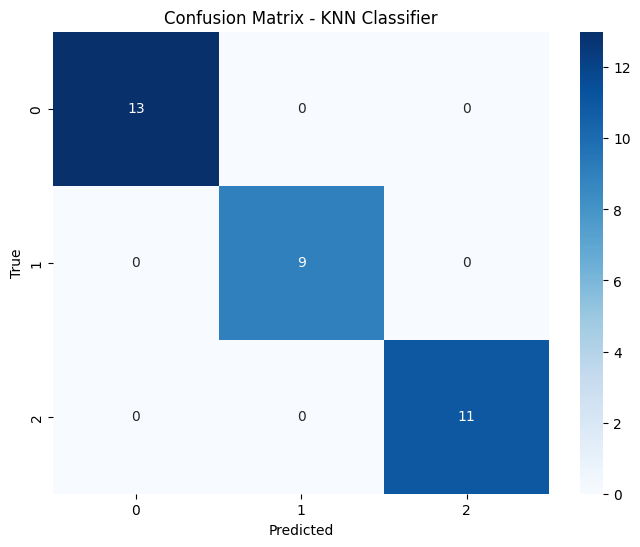

In [25]:
knn_model.set_params(**knn_best_params)
knn_model.fit(Xs_train, y_train)
print_evaluation(knn_model, "KNN Classifier", Xs_test, y_test)

<h3>Decision Tree</h3>

<h4>Best Hyperparamters for DecisionTree</h4>

In [26]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier()

# Hyperparameter grid
dt_param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring=scoring_metric)
dt_grid_search.fit(Xs_train, y_train)

# Print the best hyperparameters for Decision Tree
dt_best_params = dt_grid_search.best_params_
dt_best_params

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}

<h4>Evaluation</h4>

Decision Tree Classifier:
  Accuracy:   0.9394
  Precision:  0.9504
  Recall:     0.9394
  F1 Score:   0.9411


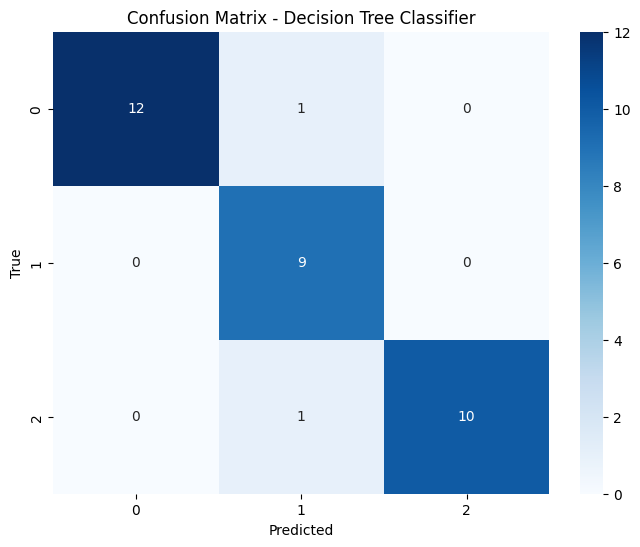

In [27]:
dt_model.set_params(**dt_best_params)
dt_model.fit(Xs_train, y_train)

print_evaluation(dt_model, "Decision Tree Classifier", Xs_test, y_test)

<h3> Bayesian classification </h3>

Gaussian Naive Bayes Classifier:
  Accuracy:   0.9394
  Precision:  0.9419
  Recall:     0.9394
  F1 Score:   0.9394


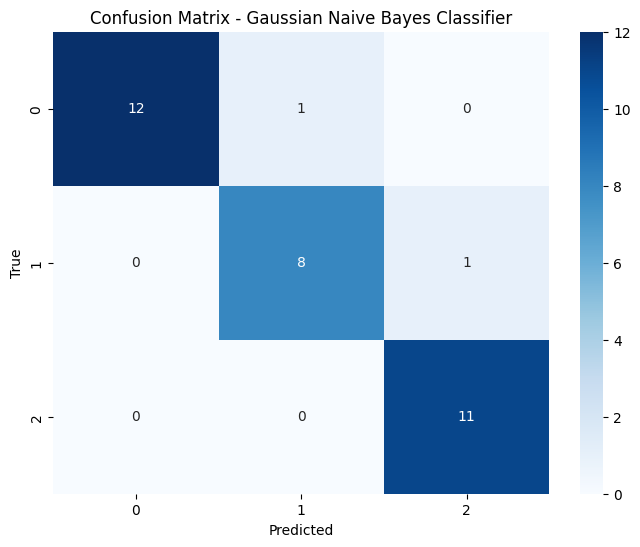

In [28]:
nb_model = GaussianNB()
nb_model.fit(Xs_train, y_train)

print_evaluation(nb_model, "Gaussian Naive Bayes Classifier", Xs_test, y_test)

<h3>Random Forest Classifier</h3>

Random Forest Classifier:
  Accuracy:   0.9697
  Precision:  0.9722
  Recall:     0.9697
  F1 Score:   0.9695


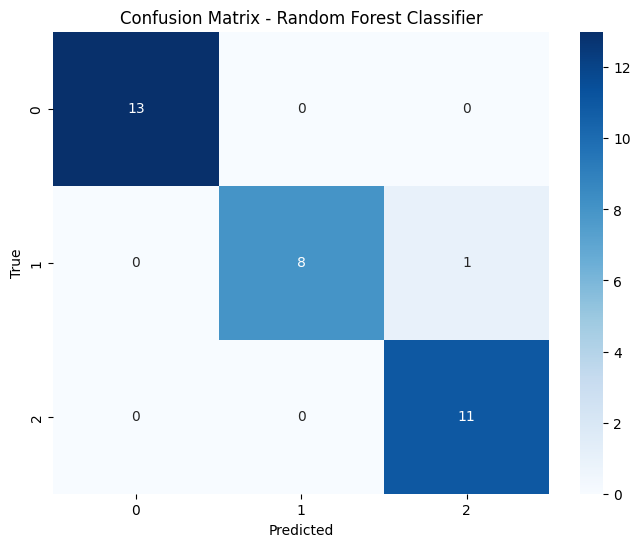

In [29]:
rf_model = RandomForestClassifier()
rf_model.fit(Xs_train, y_train)

print_evaluation(rf_model, "Random Forest Classifier", Xs_test, y_test)

In [30]:
knn_accuracy, knn_precision, knn_recall, knn_f1, knn_conf_matrix = evaluate_model(knn_model, Xs_test, y_test)
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_conf_matrix = evaluate_model(dt_model, Xs_test, y_test)
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_conf_matrix = evaluate_model(nb_model, Xs_test, y_test)
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_conf_matrix = evaluate_model(rf_model, Xs_test, y_test)

results_data = {
    'Model': ['KNN Classifier', 'Decision Tree Classifier', 'Gaussian Naive Bayes', 'Random Forest Classifier'],
    'Accuracy': [knn_accuracy, dt_accuracy, nb_accuracy, rf_accuracy],
    'Precision': [knn_precision, dt_precision, nb_precision, rf_precision],
    'Recall': [knn_recall, dt_recall, nb_recall, rf_recall],
    'f1 score': [knn_f1, dt_f1, nb_f1, rf_f1],
    "Confustion Matrix": [knn_conf_matrix, dt_conf_matrix, nb_conf_matrix, rf_conf_matrix],
}

# Create a DataFrame
results_df = pd.DataFrame(results_data)

# Display the results table using tabulate
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid')

# Display the formatted table
print("Results Table:")
print(table)

Results Table:
╒════╤══════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═════════════════════╕
│    │ Model                    │   Accuracy │   Precision │   Recall │   f1 score │ Confustion Matrix   │
╞════╪══════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═════════════════════╡
│  0 │ KNN Classifier           │   1        │    1        │ 1        │   1        │ [[13  0  0]         │
│    │                          │            │             │          │            │  [ 0  9  0]         │
│    │                          │            │             │          │            │  [ 0  0 11]]        │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────────┼─────────────────────┤
│  1 │ Decision Tree Classifier │   0.939394 │    0.950413 │ 0.939394 │   0.941097 │ [[12  1  0]         │
│    │                          │            │             │          │            │  [ 0  9  0]         │
│    │                